In [1]:
# Import a backend.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces.hypersphere import Hypersphere
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel
# import sampler
from geometric_kernels.sampling import FourierSampler

INFO: Using numpy backend


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Create a manifold (2-dim sphere).
hypersphere = Hypersphere(dim=2)

In [4]:
# create a kernel
kernel = MaternKarhunenLoeveKernel(hypersphere, 10)

In [5]:
# initialize kernel with reasonable values
params, state = kernel.init_params_and_state()
params["nu"] = np.array([5/2])
params["lengthscale"] = np.array([0.5])

In [6]:
# compute feature map for this kernel
feature_map, _ = kernel.feature_map(params, state)

In [7]:
# generate points on a sphere
lats, longs =  np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]

xs = np.sin(longs) * np.cos(lats)
ys = np.sin(longs) * np.sin(lats)
zs = np.cos(longs)

Xs = np.c_[np.ravel(xs), np.ravel(ys), np.ravel(zs)]

In [8]:
# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

In [9]:
# sample from a GP
sampler = FourierSampler(kernel)

n_samples = 4
key, samples = sampler.sample(feature_map, Xs, s=n_samples, key=key)

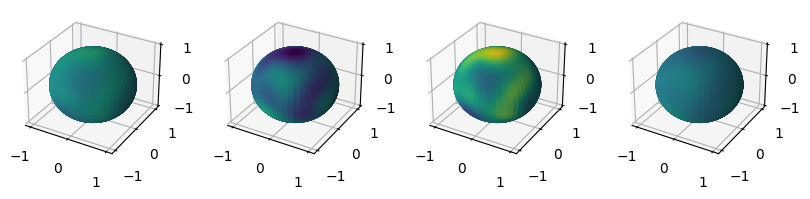

In [10]:
# Plot samples
cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=samples.min(), vmax=samples.max())
fig = plt.figure(figsize=(10,2))
for i in range(n_samples):
    sample = samples[:, i].reshape(100, 100)
    ax = fig.add_subplot(1, n_samples, i+1, projection='3d')
    ax.plot_surface(xs, ys, zs, facecolors=cmap(norm(sample)))